In [21]:
import re 

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.gridspec import GridSpec

from shapely import geometry
from src import nino34, precip, utils

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
                                
import cmaps 
from datetime import datetime

import gcgridobj 

from concurrent.futures import ProcessPoolExecutor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# DEFINE DIRECTORIES HERE
ERSST_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/ERSST/"
HADIS_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/HadISST/"
COBES_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/COBE_SST2/"

GPCC_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/GPCC/full_v2020/"
CRUT_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/CRU_TS4.06/"
APHR_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/APHRODITE/"

In [11]:
# List of CESM2 Ensemble Members
members = ['LE2-1001.001', 'LE2-1011.001', 'LE2-1021.002', 'LE2-1031.002', 'LE2-1041.003', 'LE2-1051.003',
            'LE2-1061.004', 'LE2-1071.004', 'LE2-1081.005', 'LE2-1091.005', 'LE2-1101.006', 'LE2-1111.006',
            'LE2-1121.007', 'LE2-1131.007', 'LE2-1141.008', 'LE2-1151.008', 'LE2-1161.009', 'LE2-1171.009',
            'LE2-1181.010', 'LE2-1191.010', 
            'LE2-1231.001', 'LE2-1231.002', 'LE2-1231.003', 'LE2-1231.004',
            'LE2-1231.005', 'LE2-1231.006', 'LE2-1231.007', 'LE2-1231.008', 'LE2-1231.009', 'LE2-1231.010',
            'LE2-1231.011', 'LE2-1231.012', 'LE2-1231.013', 'LE2-1231.014', 'LE2-1231.015', 'LE2-1231.016',
            'LE2-1231.017', 'LE2-1231.018', 'LE2-1231.019', 'LE2-1231.020',
            'LE2-1251.001', 'LE2-1251.002', 'LE2-1251.003', 'LE2-1251.004',
            'LE2-1251.005', 'LE2-1251.006', 'LE2-1251.007', 'LE2-1251.008', 'LE2-1251.009', 'LE2-1251.010',
            'LE2-1251.011', 'LE2-1251.012', 'LE2-1251.013', 'LE2-1251.014', 'LE2-1251.015', 'LE2-1251.016',
            'LE2-1251.017', 'LE2-1251.018', 'LE2-1251.019', 'LE2-1251.020',
            'LE2-1301.001', 'LE2-1301.002', 'LE2-1301.003', 'LE2-1301.004', 'LE2-1301.005', 'LE2-1301.006',
            'LE2-1301.007', 'LE2-1301.008', 'LE2-1301.009', 'LE2-1301.010', 'LE2-1301.011', 'LE2-1301.012', 
            'LE2-1301.013', 'LE2-1301.014', 'LE2-1301.015', 'LE2-1301.016', 'LE2-1301.017', 'LE2-1301.018',
            'LE2-1301.019', 'LE2-1301.020',
            'LE2-1281.001', 'LE2-1281.002', 'LE2-1281.003', 'LE2-1281.004', 'LE2-1281.005', 'LE2-1281.006',
            'LE2-1281.007', 'LE2-1281.008', 'LE2-1281.009', 'LE2-1281.010', 'LE2-1281.011', 'LE2-1281.012',
            'LE2-1281.013', 'LE2-1281.014', 'LE2-1281.015', 'LE2-1281.016', 'LE2-1281.017', 'LE2-1281.018',
            'LE2-1281.019', 'LE2-1281.020']
print(len(members))

100


In [3]:
# Open all precip. datasets
precip_anm_G = utils.get_obs_precip_anomalies(
    source="GPCC", 
    months=[3, 4, 5], detrend=False
    )

precip_anm_C = utils.get_obs_precip_anomalies(
    source="CRUT", 
    months=[3, 4, 5], detrend=False
    )

precip_anm_A = utils.get_obs_precip_anomalies(
    source="APHR", 
    months=[3, 4, 5], detrend=False
    )



In [7]:
# Open all Nino3.4 SST datasets
sst_anm_nino34_E = utils.get_obs_nino34_sst_anomalies(
    source="ERSST",
    detrend=False
)

sst_anm_nino34_H = utils.get_obs_nino34_sst_anomalies(
    source="HADISST", 
    detrend=False
)

sst_anm_nino34_C = utils.get_obs_nino34_sst_anomalies(
    source="COBESST", 
    detrend=False
)

In [12]:
# Open global SST datasets

sst_anm_E = utils.get_ds(
    f'{ERSST_DIR}/sst.mnmean.v5.nc'
)

sst_anm_H = utils.get_ds(
    f'{HADIS_DIR}/HadISST_sst.nc'
)

sst_anm_C = utils.get_ds(
    f'{COBES_DIR}/sst.mon.mean.nc'
)

sst_anm_E = sst_anm_E['sst'].sel(time=slice("1951-01", "2015-12"))
sst_anm_H = sst_anm_H['sst'].sel(time=slice("1951-01", "2015-12"))
sst_anm_C = sst_anm_C['sst'].sel(time=slice("1951-01", "2015-12"))

In [13]:
# Create matrix of unique precip/SST data pairs

precip_anms = [
    precip_anm_G,
    precip_anm_G,
    precip_anm_G,
    precip_anm_C,
    precip_anm_C,
    precip_anm_C,
    precip_anm_A,
    precip_anm_A,
    precip_anm_A
]

sst_anm_nino34s = [
    sst_anm_nino34_E,
    sst_anm_nino34_H,
    sst_anm_nino34_C,
    sst_anm_nino34_E,
    sst_anm_nino34_H,
    sst_anm_nino34_C,
    sst_anm_nino34_E,
    sst_anm_nino34_H,
    sst_anm_nino34_C
]

sst_anms = [
    sst_anm_E,
    sst_anm_H,
    sst_anm_C,
    sst_anm_E,
    sst_anm_H,
    sst_anm_C,
    sst_anm_E,
    sst_anm_H,
    sst_anm_C,
]

titles = [
    "a) [ERSSTv5, GPCC]", "b) [HadISSTv1.1, GPCC]", "c) [COBESST2, GPCC]",
    "d) [ERSSTv5, CRU TS4.06]", "e) [HadISSTv1.1, CRU TS4.06]", "f) [COBESST2, CRU TS4.06]",
    "g) [ERSSTv5, APHRODITE]", "h) [HadISSTv1.1, APHRODITE]", "i) [COBESST2, APHRODITE]"] 

sst_anms_unique = [
    sst_anm_E,
    sst_anm_H,
    sst_anm_C
]


In [14]:
# For each unique precip/SST data pair, calculate the regression of MSEA onto global SSTs
observed_regs = []
for i, (precip_anm, sst_anm) in enumerate(zip(precip_anms, sst_anms)):
    sst_anm0 = sst_anm.resample(time='QS-DEC', label='left').mean()
    sst_anm00 = sst_anm0.sel(time=sst_anm0.time.dt.month.isin([12])).resample(time='1Y').mean()
    sst_standardized = sst_anm00 / sst_anm00.std(dim='time')
    #regression = cov(x,y) / variance (x)
    # outcome (y) is regressed onto the predictors (x)
    cov = xr.cov(sst_standardized, precip_anm, dim="time")
    var = sst_standardized.var(dim="time", skipna=True)
    reg = cov / var
    observed_regs.append(reg)

In [16]:
# Open CESM2-LE data
def process_member(ens):
    print(f"Processing {ens}")
    sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.global.1900_2100.nc") # annual global DJF ssts
    prec_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.PRECT.MSEA.nc") # monthly MSEA ssts
    precip_anm =utils.get_model_precip_anomalies(prec_da, months=[3,4,5], detrend=False)
    
    return (precip_anm, sst_da)
    
def main(members):
    all_precips = []
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        precip_anm, sst_anm = result
        all_precips.append(precip_anm)
        all_ssts.append(sst_anm)
    return all_precips, all_ssts

all_precips, all_ssts = main(members)

Processing LE2-1001.001
Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004
Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006

Processing LE2-1111.006Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008
Processing LE2-1171.009
Processing LE2-1161.009
Processing LE2-1181.010
Processing LE2-1191.010
Processing LE2-1231.001
Processing LE2-1231.002
Processing LE2-1231.003
Processing LE2-1231.004
Processing LE2-1231.005
Processing LE2-1231.006
Processing LE2-1231.007
Processing LE2-1231.009
Processing LE2-1231.011
Processing LE2-1231.008
Processing LE2-1231.010
Processing LE2-1231.012Processing LE2-1231.013

Processing LE2-1231.014
Processing LE2-1231.015
Processing LE2-1231.016
Processing LE2-1231.017
Processing LE2-1231.018Processing LE2-1231.019

Processing LE2-1231.020
Processing LE2-1251.002
Processing LE2-1

In [24]:
# Calculate min, max, and mean of running correlation coefficients
N=13
corr_lead_nino34s = []
for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    corr_lead_nino34 = utils.get_running_corr(sst_anm_nino34.shift(time=1), precip_anm, window=N)
    corr_lead_nino34s.append(corr_lead_nino34.corr)

corr_lead_nino34s_da = xr.concat(corr_lead_nino34s, dim='datasets')
max = corr_lead_nino34s_da.max(dim='datasets')
min = corr_lead_nino34s_da.min(dim='datasets')
mean = corr_lead_nino34s_da.mean(dim='datasets')

In [28]:
# Figure 1a: Map of MAM precipitation in MSEA region
file =  f'{GPCC_DIR}/precip.mon.total.0.5x0.5.v2020.nc'
ds0 = utils.get_ds(file)
precip_ds = ds0.sel(time=slice("1951-01", "2015-12"))
precip_da = precip_ds["precip"]
anm_map = precip.get_SEAM_map(precip_da, monsoon_season=False, monthly=True, detrend=False, anomaly=False, base_start=None, base_end=None)
anm_map_premonsoon = anm_map.sel(time=anm_map.time.dt.season=="MAM")


In [29]:
# Figure 1d: Map of CESM2-LE mean regression of MSEA index onto global SSTs
precips_da = xr.concat(all_precips, dim='ensemble')
ssts_da = xr.concat(all_ssts, dim='ensemble').isel(z_t=0, drop=True)
ssts_da_sel = ssts_da['SST'].sel(time=slice('1951', '2015'))
precips_da_sel = precips_da.sel(time=slice('1951', '2015'))
sst_standardized = ssts_da_sel / ssts_da_sel.std(dim='time')
cov = xr.cov(sst_standardized, precips_da_sel, dim="time")
var = sst_standardized.var(dim="time", skipna=True)
reg_model = cov / var
reg_model_mean = reg_model.mean(dim='ensemble')
signs = np.sign(reg_model) # Create a mask where all ensemble members agree on the sign of the regression
sum_signs = np.sum(signs, axis=0)
mask = np.abs(sum_signs) >= 100

In [31]:
# Figure 1c: Map of observed mean regression of MSEA index onto global SSTs
reg_mean_ds = reg_model_mean.to_dataset(name='cesm')
dst_grid = gcgridobj.latlontools.extract_grid(reg_mean_ds)
lat = reg_mean_ds['lat'].values
lon = reg_mean_ds['lon'].values

sst_anms_regridded = []

# Times differ in format but are otherwise identical
ds = sst_anms_unique[0].sel(time=slice("1951-01", "2015-12"))
time = ds.time.values

# For each unique SST dataset, regrid to match CESM2 grid and then append to a list
for i, (sst_anm_unique) in enumerate(sst_anms_unique):
    ds = sst_anm_unique.sel(time=slice("1951-01", "2015-12"))

    src_grid = gcgridobj.latlontools.extract_grid(sst_anm_unique.to_dataset(name='sst'))
    regridder = gcgridobj.regrid.gen_regridder(src_grid, dst_grid)
    da_regridded = regridder(sst_anm_unique)
    sst_da = xr.DataArray(da_regridded, coords={'time': time, 'lat': lat, 
                                    'lon': lon},
                dims=['time', 'lat', 'lon'])

    sst_anms_regridded.append(sst_da)    

In [32]:
# For each precip/SST (regridded) data pair, calculate observed regression
observed_regs_regridded = []
for i, (precip_anm, sst_anm) in enumerate(zip(precip_anms, sst_anms_regridded)):
    sst_anm0 = sst_anm.resample(time='QS-DEC', label='left').mean()
    sst_anm00 = sst_anm0.sel(time=sst_anm0.time.dt.month.isin([12])).resample(time='1Y').mean()
    sst_standardized = sst_anm00 / sst_anm00.std(dim='time')
    #regression = cov(x,y) / variance (x)
    # outcome (y) is regressed onto the predictors (x)
    cov = xr.cov(sst_standardized, precip_anm, dim="time")
    var = sst_standardized.var(dim="time", skipna=True)
    reg = cov / var
    observed_regs_regridded.append(reg)

In [33]:
observed_regs_regridded_da = xr.concat(observed_regs_regridded, dim="datasets")

In [34]:
# Create a mask where all observations members agree on the sign of the regression
signs_obs = np.sign(observed_regs_regridded_da)
sum_signs_obs = np.sum(signs_obs, axis=0)
mask_obs = np.abs(sum_signs_obs) >= 9

In [35]:
def make_precip_map(anm_map, ax):
        
    y = anm_map.mean(dim='time')
    lon = y["lon"]
    lat = y["lat"]

    im = ax.contourf(
            y.lon,
            y.lat,
            y,
            cmap=cmaps.CBR_wet,
            transform=ccrs.PlateCarree(),
            extend="max",
            levels=[0,25,50,75,100,125,150,175,200]
        )

    # Gridlines
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.1, color="gray", alpha=0.5
    )
    
    ax.set_extent([80,120,0,35], crs=ccrs.PlateCarree())

    ax.set_xticks([90, 110],crs=ccrs.PlateCarree())
    ax.set_xticklabels([90, 110],fontsize=8)
    ax.set_yticks([10,25],crs=ccrs.PlateCarree())
    ax.set_yticklabels([10,25],fontsize=8)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
  
    cax,kw = mpl.colorbar.make_axes(ax, location='right', pad=0.1, shrink=0.97, aspect=15)
    cbar = fig.colorbar(im, ticks=[0,50, 100, 150, 200], cax=cax, **kw)
    #cbar.set_label('mm/month', fontsize=8)
    cbar.ax.set_title('mm/month')

    cbar.outline.set_linewidth(0.5)

    geom = geometry.box(minx=90,maxx=110, miny=10,maxy=25)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=.5)


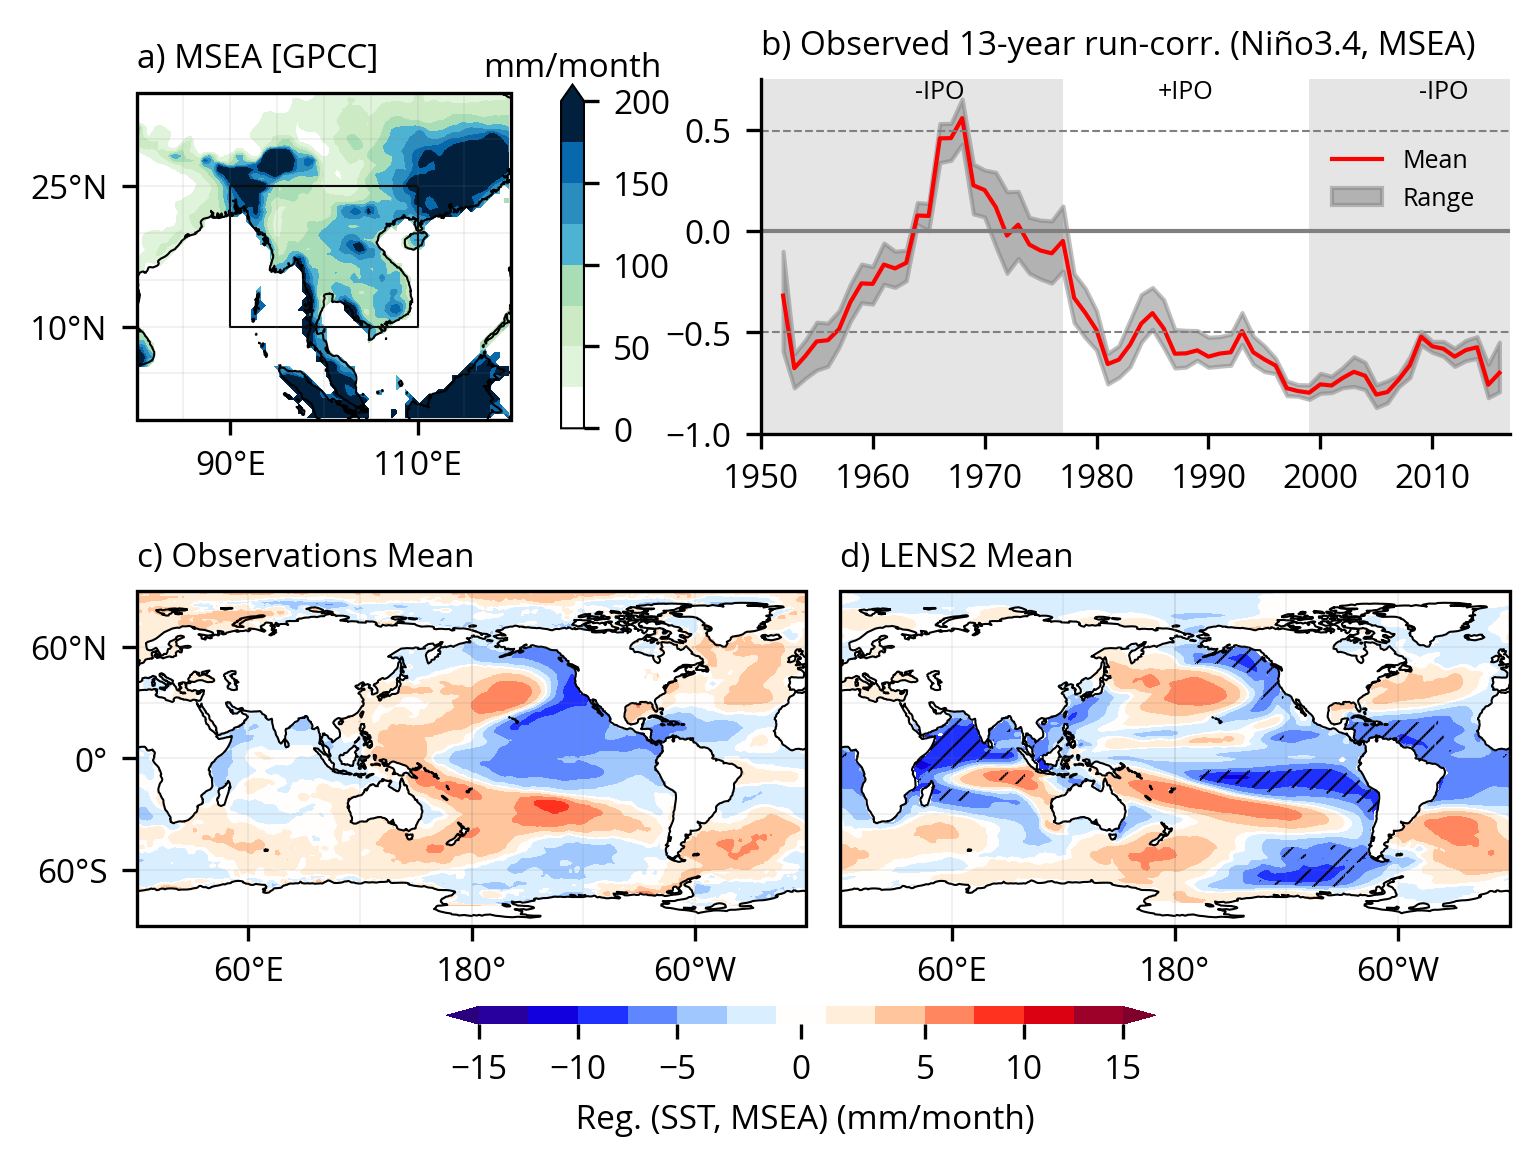

In [36]:
# Set global parameters
%matplotlib inline

utils.set_matplotlib_font("Open Sans")

color = 'black'

mpl.rcParams.update({
    'axes.edgecolor': color,      # Color of the axes spines
    'xtick.color': color,         # Color of the x-axis ticks
    'ytick.color': color,         # Color of the y-axis ticks
    'xtick.labelcolor': color,    # Color of the x-axis tick labels
    'ytick.labelcolor': color,    # Color of the y-axis tick labels
    'grid.color': color,          # Color of the grid lines
    'axes.labelcolor': color,     # Color of the axis labels
    'axes.titlecolor': color,     # Color of the plot titles
})

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 15 
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)

gs1 = GridSpec(1, 2, top=0.95, bottom=0.65, wspace=0.2, width_ratios=[0.4, 0.6])
ax1 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs1[0, 1])

gs2 = GridSpec(1, 2, top=0.60, bottom=0.15, hspace = 0.28, wspace=0.05)
ax3 = fig.add_subplot(gs2[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax4 = fig.add_subplot(gs2[0, 1], projection=ccrs.PlateCarree(central_longitude=180))

############## Figure 1b ##############
N = 13
crit = 0.497 # critical r-value at 90% confidence level

dates0 = np.array(['1951-12-31T00:00:00.000000000', '1952-12-31T00:00:00.000000000',
                  '1953-12-31T00:00:00.000000000', '1954-12-31T00:00:00.000000000',
                  '1955-12-31T00:00:00.000000000', '1956-12-31T00:00:00.000000000',
                  '1957-12-31T00:00:00.000000000', '1958-12-31T00:00:00.000000000',
                  '1959-12-31T00:00:00.000000000', '1960-12-31T00:00:00.000000000',
                  '1961-12-31T00:00:00.000000000', '1962-12-31T00:00:00.000000000',
                  '1963-12-31T00:00:00.000000000', '1964-12-31T00:00:00.000000000',
                  '1965-12-31T00:00:00.000000000', '1966-12-31T00:00:00.000000000',
                  '1967-12-31T00:00:00.000000000', '1968-12-31T00:00:00.000000000',
                  '1969-12-31T00:00:00.000000000', '1970-12-31T00:00:00.000000000',
                  '1971-12-31T00:00:00.000000000', '1972-12-31T00:00:00.000000000',
                  '1973-12-31T00:00:00.000000000', '1974-12-31T00:00:00.000000000',
                  '1975-12-31T00:00:00.000000000', '1976-12-31T00:00:00.000000000',
                  '1977-12-31T00:00:00.000000000', '1978-12-31T00:00:00.000000000',
                  '1979-12-31T00:00:00.000000000', '1980-12-31T00:00:00.000000000',
                  '1981-12-31T00:00:00.000000000', '1982-12-31T00:00:00.000000000',
                  '1983-12-31T00:00:00.000000000', '1984-12-31T00:00:00.000000000',
                  '1985-12-31T00:00:00.000000000', '1986-12-31T00:00:00.000000000',
                  '1987-12-31T00:00:00.000000000', '1988-12-31T00:00:00.000000000',
                  '1989-12-31T00:00:00.000000000', '1990-12-31T00:00:00.000000000',
                  '1991-12-31T00:00:00.000000000', '1992-12-31T00:00:00.000000000',
                  '1993-12-31T00:00:00.000000000', '1994-12-31T00:00:00.000000000',
                  '1995-12-31T00:00:00.000000000', '1996-12-31T00:00:00.000000000',
                  '1997-12-31T00:00:00.000000000', '1998-12-31T00:00:00.000000000',
                  '1999-12-31T00:00:00.000000000', '2000-12-31T00:00:00.000000000',
                  '2001-12-31T00:00:00.000000000', '2002-12-31T00:00:00.000000000',
                  '2003-12-31T00:00:00.000000000', '2004-12-31T00:00:00.000000000',
                  '2005-12-31T00:00:00.000000000', '2006-12-31T00:00:00.000000000',
                  '2007-12-31T00:00:00.000000000', '2008-12-31T00:00:00.000000000',
                  '2009-12-31T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
                  '2011-12-31T00:00:00.000000000', '2012-12-31T00:00:00.000000000',
                  '2013-12-31T00:00:00.000000000', '2014-12-31T00:00:00.000000000',
                  '2015-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

dates = dates0.astype('datetime64[D]').astype(datetime)

ax2.plot(
        dates,
        mean,
        linestyle='-',
        color='red',
        linewidth=1,
        label="Mean"
    )

ax2.fill_between(
        dates,
        min, 
        max, 
        color='grey', 
        alpha=0.5,
        label="Range"
    )

ax2.legend(fontsize=6, frameon=False, loc=[0.75,0.6])


# Remove top and right spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Draw 90% confidence level for correlation coefficient of length 13-years
ax2.axhline(-crit, color="grey", linestyle='--', label=None, linewidth=0.5)
ax2.axhline(+crit, color="grey", linestyle='--', label=None, linewidth=0.5)

# Shade in grey negative periods of the IPO (determined how?)
ax2.axvspan('1948', '1977', alpha=0.2, facecolor='grey', edgecolor=None)
#ax2.axvspan('1969', '1977', alpha=0.2, facecolor='grey', edgecolor=None)
ax2.axvspan('1999', '2023', alpha=0.2, facecolor='grey', edgecolor=None)

# Adding "+IPO" in the middle of each grey box at the top
grey_midpoints = [datetime(1966, 1, 1), datetime(2011, 1, 1)]
for midpoint in grey_midpoints:
    ax2.text(midpoint, 1, '-IPO', ha='center', va='top', fontsize=6, transform=ax2.get_xaxis_transform())

# Adding "-IPO" in the middle of each white space at the top
white_midpoints = [datetime(1988, 1, 1)]
for midpoint in white_midpoints:
    ax2.text(midpoint, 1, '+IPO', ha='center', va='top', fontsize=6, transform=ax2.get_xaxis_transform())

# Draw horizontal line at 0
ax2.axhline(0, color="grey", linewidth=1, label=None)

# Set x- and y- labels and axes
ax2.xaxis.set_major_locator(mpl.dates.YearLocator(base=10))

ax2.set_xlim(pd.Timestamp("1950-01-01"), pd.Timestamp("2016-12-01"))
ax2.set_ylim([-1,0.75])

ax2.set_ylabel(None)
ax2.tick_params(axis='both', which='major', labelsize=8)  # Set tick params for ax1

############## Figure 1a ##############
make_precip_map(anm_map_premonsoon, ax1)

############## Figure 1d ##############

# add cyclic point at lon=320 (white vertical line)
y = reg_model_mean
y.sel(lon=320, method='nearest')[:] = y.sel(lon=321, method='nearest')

im = draw_regression_map(y, ax4)

# Add hatching where the ensemble members agree on the sign of the regression
hatching = ax4.pcolor(reg_model_mean.lon, reg_model_mean.lat, reg_model_mean.where(mask), hatch='/////', alpha=0, transform=ccrs.PlateCarree())
hatching.set_linewidth(0.5)  # Adjust linewidth for hatches
ax4.set_global()  # default CESM output is not global

############## Figure 1c ##############
reg = observed_regs_regridded_da.mean(dim="datasets")
im = draw_regression_map(reg, ax3)
ax3.set_global()

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

# Add hatching where the observations agree on the sign of the regression
hatching = ax3.pcolor(observed_regs_regridded_da.lon, observed_regs_regridded_da.lat, reg.where(mask_obs), hatch='/////', alpha=0, transform=ccrs.PlateCarree())
hatching.set_linewidth(0.5)  # Adjust linewidth for hatches

axs = [ax3]
for i, ax in enumerate(axs):

    ax.set_yticks([-60, 0, 60], crs=ccrs.PlateCarree())
    ax.set_yticklabels([-60, 0, 60], fontsize=8)

    ax.tick_params(axis='y', which='major', labelsize=8)  # Set tick params for each ax

    ax.yaxis.set_major_formatter(lat_formatter)

    ax.set_xticks([60, 180, 300], crs=ccrs.PlateCarree())
    ax.set_xticklabels([60, 180, 300], fontsize=8)

    ax.xaxis.set_major_formatter(lon_formatter)

axs = [ax4]
for i, ax in enumerate(axs):

    ax.set_xticks([60, 180, 300], crs=ccrs.PlateCarree())
    ax.set_xticklabels([60, 180, 300], fontsize=8)

    ax.set_xticks([60, 180, 300], crs=ccrs.PlateCarree())
    ax.set_xticklabels([], fontsize=8)

    ax.xaxis.set_major_formatter(lon_formatter)

# Set subplot labels
titles = ["a) MSEA [GPCC]", "b) Observed 13-year run-corr. (Niño3.4, MSEA)", "c) Observations Mean", "d) LENS2 Mean"]
for i, (ax, title) in enumerate(zip([ax1, ax2, ax3, ax4], titles)):
    ax.set_title(title, loc="left", fontsize=8)

# Add colorbar
cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(im,  cax=cbar_ax, ticks=[-15, -10, -5, 0, 5, 10, 15], orientation="horizontal", shrink=0.50, label=' Reg. (SST, MSEA) (mm/month)')
cbar.ax.tick_params(labelsize=8)
cbar.outline.set_visible(False)


plt.savefig("Fig1.png")
